In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import taxcalc as tc
from taxbrain import (
    TaxBrain, differences_plot, distribution_plot, volcano_plot
)
from bokeh.io import output_notebook, show

In [25]:
output_notebook()
pd.options.display.float_format = '{:,.3f}'.format

Loading BokehJS ...

In [26]:
# Set paths to work across Mac/Windows/Linux platforms
# Update cur_path to the path of the repsitory on your local machine
cur_path = "/Users/richardevans/Docs/Economics/OSE/Federal/CharitableContrib"
data_dir = os.path.join(cur_path, 'data')
images_dir = os.path.join(cur_path, 'images')
# Directories to save data
json_dir = os.path.join(cur_path, "json")
tmd_dir = (
    "/Users/richardevans/Docs/Economics/OSE/microsim/" +
    "tax-microdata-benchmarking/tmd/storage/output"
)

## 1. Create Descriptive Images

In [161]:
# Create a Pandas DataFrame of percent of filers who take the standard
# deduction.
# 2022:
# 2021: https://www.irs.gov/pub/irs-pdf/p1304.pdf
# 2020: https://www.irs.gov/pub/irs-soi/soi-a-inpr-id2201.pdf
# 2019: https://www.irs.gov/pub/irs-prior/p1304--2021.pdf
# 2018: https://www.irs.gov/pub/irs-prior/p1304--2020.pdf
# 2017: https://www.irs.gov/pub/irs-soi/17inintaxreturns.pdf
# 2016: https://www.irs.gov/pub/irs-soi/16inintaxreturns.pdf
# 2015: https://www.irs.gov/pub/irs-soi/15inintaxreturns.pdf
pct_std_deduct = pd.DataFrame({
    'year': [2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015],
    'pct_std_deduct': [88.6, 88.2, 87.5, 88.9, 87.3, 68.0, 68.6, 69.0],
    'std_deduct_joint': [
        25900, 25100, 24800, 24400, 24000, 12700, 12600, 12600
    ],
    'std_deduct_single': [
        12950, 12550, 12400, 12200, 12000, 6350, 6300, 6300
    ],
    'chtbl_deduct_nonitem_joint': [0, 600, 300, 0, 0, 0, 0, 0],
    'chtbl_deduct_nonitem_other': [0, 300, 150, 0, 0, 0, 0, 0],
})
pct_std_deduct['std_deduct_plus_joint'] = (
    pct_std_deduct['std_deduct_joint'] +
    pct_std_deduct['chtbl_deduct_nonitem_joint']
)
pct_std_deduct['std_deduct_plus_other'] = (
    pct_std_deduct['std_deduct_single'] +
    pct_std_deduct['chtbl_deduct_nonitem_other']
)

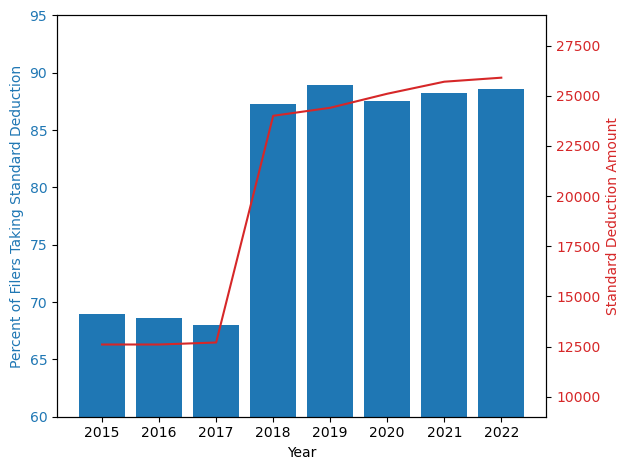

In [162]:
# Make a plot with a left y-axis for the percent of filers who take the
# standard deduction and a right y-axis for the std_deduct_joint amount.
fig1, ax1 = plt.subplots()
color_pct = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Percent of Filers Taking Standard Deduction', color=color_pct)
ax1.bar(
    pct_std_deduct['year'], pct_std_deduct['pct_std_deduct'], color=color_pct,
    label='Percent of Filers Taking Standard Deduction'
)
ax1.tick_params(axis='y', labelcolor=color_pct)
ax2 = ax1.twinx()
color_std = 'tab:red'
ax2.set_ylabel('Standard Deduction Amount', color=color_std)
ax2.plot(
    pct_std_deduct['year'], pct_std_deduct['std_deduct_plus_joint'],
    color=color_std, label='Standard Deduction Amount (married, joint)'
)
ax2.tick_params(axis='y', labelcolor=color_std)
# Set ax1 y-axis limits to 20-100 and ax2 y-axis limits to 10000-30000.
ax1.set_ylim(60, 95)
ax2.set_ylim(9000, 29000)
# Put a note below the plot with the source of the data.
# sub_plot_text = (
#     "Note: Percent of filers taking the standard deduction data come from the IRS year-end complete reports. The standard deduction amount comes these same reports. The standard deduction amounts include the above-the-line charitable deduction amounts for non-itemizers in 2020 and 2021."
# )
# plt.figtext(
#     0.5, 0.01, sub_plot_text, wrap=True, horizontalalignment='center', fontsize=12
# )
fig1.tight_layout()
# plt.title(
#     'Percent of Filers Taking Standard Deduction and Standard Deduction Amount'
# )
# plt.legend(loc='upper left')
# Save the plot as StdDeduct_pct_take.png in the images_dir directory.
plt.savefig(os.path.join(images_dir, 'StdDeduct_pct_take.png'))
plt.show()

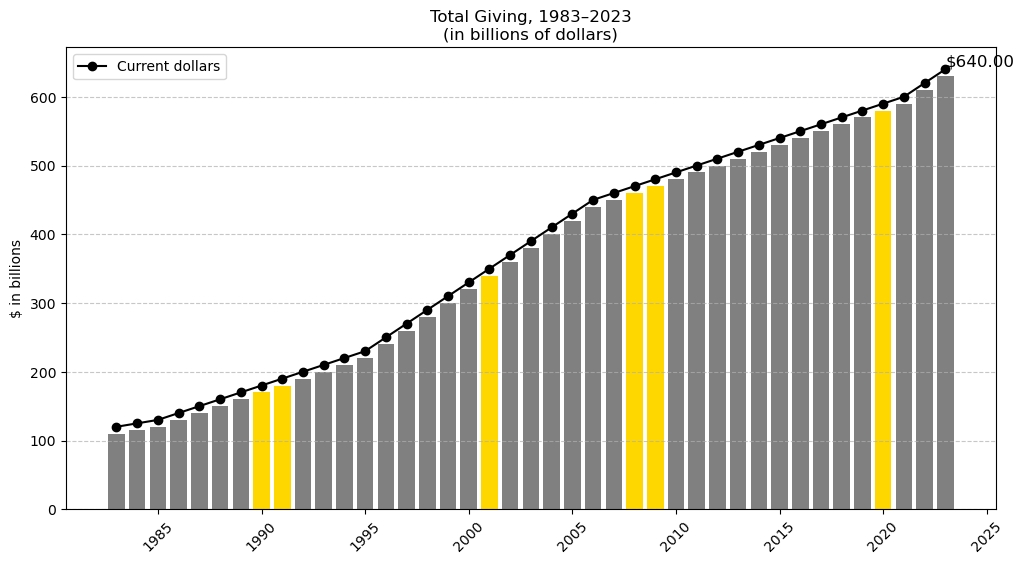

In [163]:
# Manually adjusted data to closely match the original chart
years = np.arange(1983, 2024)
total_giving_current = [120, 125, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 250, 270, 290, 310, 330, 350, 370, 390, 410, 430, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 620, 640]  # Updated values
inflation_adjusted = [110, 115, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 610, 630]  # Adjusted to match better

# Mark recession years (as seen in yellow bars)
recession_years = {1990, 1991, 2001, 2008, 2009, 2020}  # Example years

plt.figure(figsize=(12, 6))

# Plot inflation-adjusted dollars as bars
for year, value in zip(years, inflation_adjusted):
    color = 'gold' if year in recession_years else 'gray'
    plt.bar(year, value, color=color)

# Plot current dollars as a line plot
plt.plot(years, total_giving_current, marker='o', color='black', linestyle='-', label='Current dollars')

# Annotate the last value
plt.text(years[-1], total_giving_current[-1], f'${total_giving_current[-1]:.2f}', fontsize=12, verticalalignment='bottom')

# Labels and legend
plt.title("Total Giving, 1983–2023\n(in billions of dollars)")
plt.ylabel("$ in billions")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [164]:
# Read in data
item_by_agi_dir = os.path.join(data_dir, "IRS_SOI/item_by_agi")
item_by_age_dir = os.path.join(data_dir, "IRS_SOI/item_by_age")
inc_range_lst = [
    "all_returns_total", "under_5k", "5k-10k", "10k-15k", "15k-20k", "20k-25k",
    "25k-30k", "30k-35k", "35k-40k", "40k-45k", "45k-50k", "50k-55k",
    "55k-60k", "60k-75k", "75k-100k", "100k-200k", "200k-500k", "500k-1m",
    "1m-1.5m", "1.5m-2m", "2m-5m", "5m-10m", "10m_over",
    "taxable_returns_total", "nontaxable_returns_total"
]
age_range_lst = [
    "all_returns", "under_18", "18-25", "26-34", "35-44", "45-54", "55-64",
    "65_over"
]
var_list = [
    "num_returns", "agi_less_def", "total_income", "item_ded_tot",
    "contrib_num", "contrib_tot"
]
var_col_sheet_names_agi = [
    ["B", "C", "E", "BH", "CS", "CT"],
    ["B", "C", "E", "BH", "CS", "CT"],
    ["B", "C", "E", "BJ", "CU", "CV"],
    ["B", "C", "E", "BL", "CY", "CZ"],
    ["B", "C", "E", "BN", "DC", "DD"],
    ["B", "C", "E", "BJ", "CY", "CZ"],
    ["B", "C", "E", "BH", "CW", "CX"],
    ["B", "C", "E", "BT", "DG", "DH"]]
# Create blank DataFrame for data by AGI and data by age for each variable with
# dates as rows and income ranges or age ranges as columns/variables
year_lst = list(range(2015, 2023))
for var in var_list:
    if var == "num_returns" or var == "contrib_num":
        data_type = "int64"
    else:
        data_type = "float64"
    exec(
        f"{var}_age_df = pd.DataFrame(columns=['year']+age_range_lst, dtype=np.{data_type})"
    )
    exec(
        f"{var}_agi_df = pd.DataFrame(columns=['year']+inc_range_lst, dtype=np.{data_type})"
    )

for ind_year, year in enumerate(year_lst):  # Loop through years 2015 to 2022
    two_digit_year = str(year)[2:]  # Get the last two digits of the year
    for ind_var, var in enumerate(var_list):
        print(year, var)
        # Add a row to the DataFrame and set the year = year
        exec(f"{var}_age_df.loc[ind_year, 'year'] = year")
        exec(f"{var}_agi_df.loc[ind_year, 'year'] = year")
        # Create a list from the column of an xls file
        age_data = pd.read_excel(
            os.path.join(item_by_age_dir, f"{two_digit_year}in26ag.xls"),
            sheet_name="TBL21", header=None, names=["variable"],
            usecols=var_col_sheet_names_agi[ind_year][ind_var],
            skiprows=9, nrows=8
        )["variable"].tolist()
        exec(f"{var}_age_df.loc[ind_year, age_range_lst] = age_data")
        agi_data = pd.read_excel(
            os.path.join(item_by_agi_dir, f"{two_digit_year}in21id.xls"),
            sheet_name="TBL21", header=None, names=["variable"],
            usecols=var_col_sheet_names_agi[ind_year][ind_var],
            skiprows=9, nrows=25
        )["variable"].tolist()
        exec(f"{var}_agi_df.loc[ind_year, inc_range_lst] = agi_data")

irs_soi_data_dct = {
    "num_returns_age": num_returns_age_df,
    "agi_less_def_age": agi_less_def_age_df,
    "total_income_age": total_income_age_df,
    "item_ded_tot_age": item_ded_tot_age_df,
    "contrib_num_age": contrib_num_age_df,
    "contrib_tot_age": contrib_tot_age_df,
    "num_returns_agi": num_returns_agi_df,
    "agi_less_def_agi": agi_less_def_agi_df,
    "total_income_agi": total_income_agi_df,
    "item_ded_tot_agi": item_ded_tot_agi_df,
    "contrib_num_agi": contrib_num_agi_df,
    "contrib_tot_agi": contrib_tot_agi_df
}

2015 num_returns
2015 agi_less_def
2015 total_income
2015 item_ded_tot
2015 contrib_num
2015 contrib_tot
2016 num_returns
2016 agi_less_def
2016 total_income
2016 item_ded_tot
2016 contrib_num
2016 contrib_tot
2017 num_returns
2017 agi_less_def
2017 total_income
2017 item_ded_tot
2017 contrib_num
2017 contrib_tot
2018 num_returns
2018 agi_less_def
2018 total_income
2018 item_ded_tot
2018 contrib_num
2018 contrib_tot
2019 num_returns
2019 agi_less_def
2019 total_income
2019 item_ded_tot
2019 contrib_num
2019 contrib_tot
2020 num_returns
2020 agi_less_def
2020 total_income
2020 item_ded_tot
2020 contrib_num
2020 contrib_tot
2021 num_returns
2021 agi_less_def
2021 total_income
2021 item_ded_tot
2021 contrib_num
2021 contrib_tot
2022 num_returns
2022 agi_less_def
2022 total_income
2022 item_ded_tot
2022 contrib_num
2022 contrib_tot


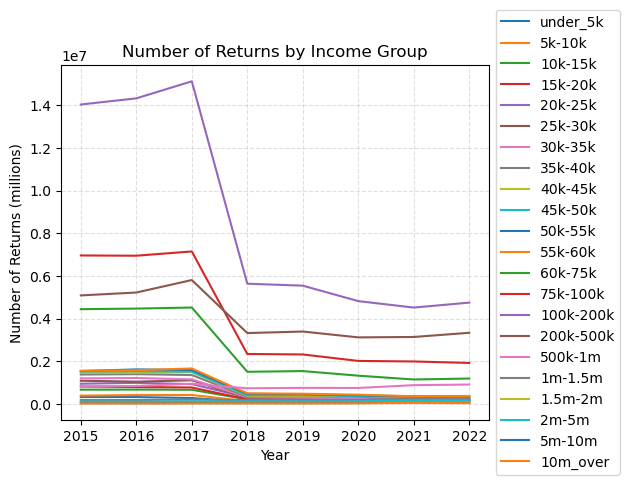

In [165]:
# Plot the time series of number of returns by income group
for var in inc_range_lst:
    if var not in ["all_returns_total", "taxable_returns_total", "nontaxable_returns_total"]:
        plt.plot(num_returns_agi_df['year'], num_returns_agi_df[var], label=var)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Number of Returns (millions)')
plt.title('Number of Returns by Income Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'NumReturns_inc.png'))
plt.show()

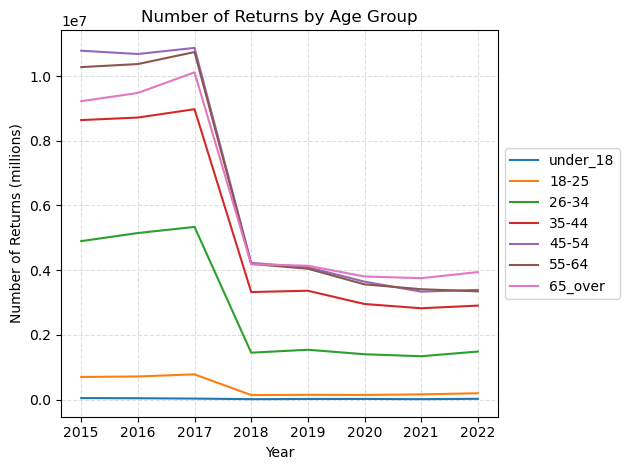

In [166]:
# Plot the time series of number of returns by age group
for var in age_range_lst:
    if var not in ["all_returns"]:
        plt.plot(num_returns_age_df['year'], num_returns_age_df[var], label=var)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Number of Returns (millions)')
plt.title('Number of Returns by Age Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'NumReturns_age.png'))
plt.show()

In [167]:
# Create a percent change variable for the series contrib_tot_agi_df["all_returns_total"]
contrib_tot_agi_df["all_returns_total_pct_change"] = (
    contrib_tot_agi_df["all_returns_total"].pct_change() * 100
)
# Create a simple difference variable for the series contrib_tot_agi_df["all_returns_total"]
contrib_tot_agi_df["all_returns_total_diff"] = (
    contrib_tot_agi_df["all_returns_total"].diff()
) * 1_000
contrib_tot_agi_df[["year", "all_returns_total", "all_returns_total_diff", "all_returns_total_pct_change"]]

,year,all_returns_total,all_returns_total_diff,all_returns_total_pct_change
0,$2015.000,$221850264.000,NaN,NaN
1,$2016.000,$233867324.000,$12017060000.000,$5.417
2,$2017.000,$256064685.000,$22197361000.000,$9.491
3,$2018.000,$196956414.000,$-59108271000.000,$-23.083
4,$2019.000,$190114194.000,$-6842220000.000,$-3.474
5,$2020.000,$204663042.000,$14548848000.000,$7.653
6,$2021.000,$263250541.000,$58587499000.000,$28.626
7,$2022.000,$222384855.000,$-40865686000.000,$-15.523


/var/folders/d4/trj3dssd6s3g8kxvjmczz11w0000gn/T/ipykernel_36742/4291640844.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


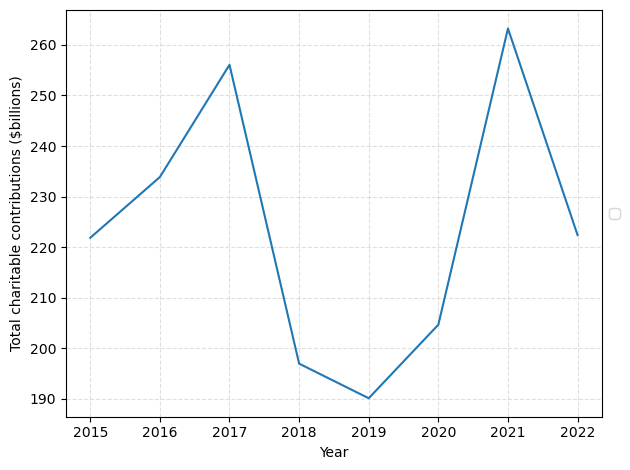

In [168]:
plt.plot(contrib_tot_agi_df['year'], contrib_tot_agi_df["all_returns_total"] * 1_000 / 1e9)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Total charitable contributions ($billions)')
# plt.title('Total cash and noncash charitable contributions: 2015-2022')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'TotContributions.png'))
plt.show()

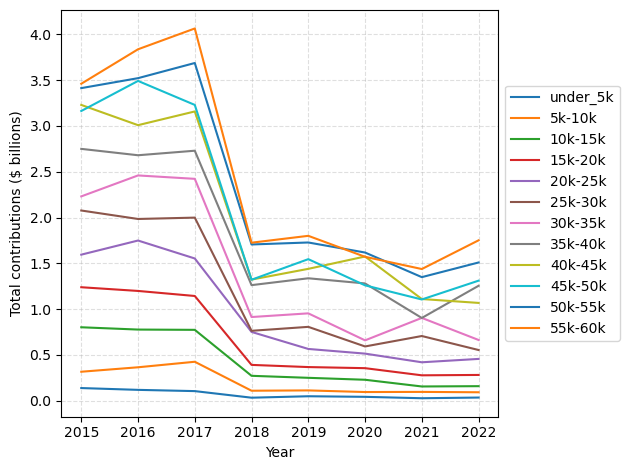

In [169]:
# Plot the time series of total contributions amount by income group
for var in inc_range_lst[:13]:
    if var not in ["all_returns_total", "taxable_returns_total", "nontaxable_returns_total"]:
        # if var in ["2m-5m", "5m-10m", "10m_over"]:
        #     plt.plot(contrib_tot_agi_df['year'], contrib_tot_agi_df[var], label=var, color='black')
        # else:
        #     plt.plot(contrib_tot_agi_df['year'], contrib_tot_agi_df[var], label=var)
        plt.plot(
            contrib_tot_agi_df['year'], contrib_tot_agi_df[var] * 1_000 / 1e9,
            label=var
        )
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Total contributions ($ billions)')
# plt.title('Total charitable contributions by Income Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'TotContrib_inc.png'))
plt.show()

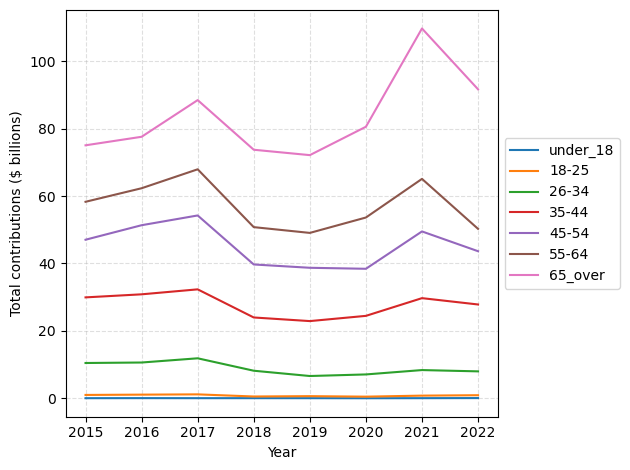

In [170]:
# Plot the time series of total contributions amount by age group
for var in age_range_lst:
    if var not in ["all_returns"]:
        plt.plot(
            contrib_tot_age_df['year'], contrib_tot_age_df[var] * 1_000 / 1e9,
            label=var
        )
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Total contributions ($ billions)')
# plt.title('Total charitable contributions by Age Group: 2015-2022')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'TotContrib_age.png'))
plt.show()

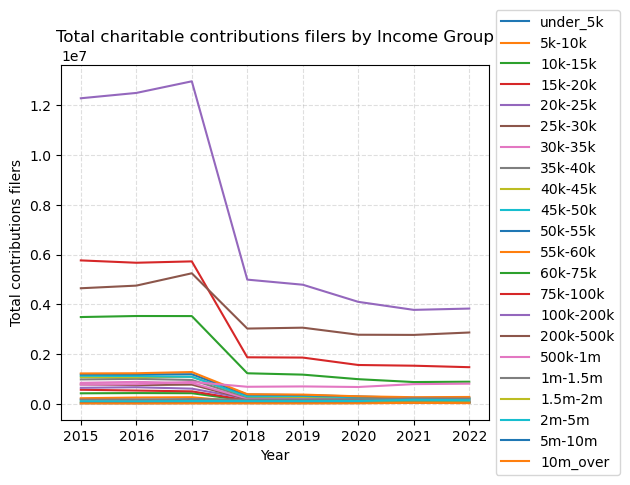

In [171]:
# Plot the time series of total contributions filers by income group
for var in inc_range_lst:
    if var not in ["all_returns_total", "taxable_returns_total", "nontaxable_returns_total"]:
        plt.plot(contrib_num_agi_df['year'], contrib_num_agi_df[var], label=var)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Total contributions filers')
plt.title('Total charitable contributions filers by Income Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'TotContrib_num_inc.png'))
plt.show()

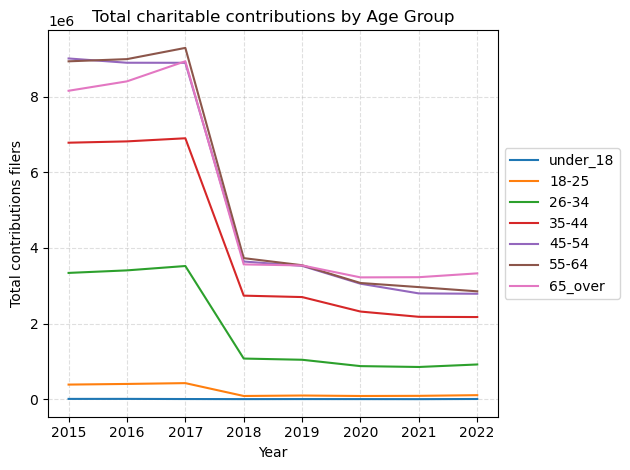

In [172]:
# Plot the time series of total contributions filers amount by age group
for var in age_range_lst:
    if var not in ["all_returns"]:
        plt.plot(contrib_num_age_df['year'], contrib_num_age_df[var], label=var)
plt.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.4)
plt.xlabel('Year')
plt.ylabel('Total contributions filers')
plt.title('Total charitable contributions by Age Group')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(images_dir, 'TotContrib_num_age.png'))
plt.show()

## 2. Run Tax-Calculator analysis for first analysis (Mar. 2025)

### 2.1. Setup baseline calculator

In [105]:
# Set up the baseline calculator
base_pol = tc.policy.Policy()
base_pol_dict = base_pol.read_json_reform(os.path.join(json_dir, "ext.json"))
base_pol.implement_reform(base_pol_dict)
gfactors=tc.growfactors.GrowFactors(
    growfactors_filename=os.path.join(tmd_dir, "tmd_growfactors_jason.csv")
)
# rec = tc.records.Records.cps_constructor()
rec = tc.records.Records(
    data=os.path.join(tmd_dir, "tmd_jason.csv.gz"),
    start_year=tc.records.Records.TMDCSV_YEAR,
    gfactors=gfactors,
    weights=os.path.join(tmd_dir, "tmd_weights_jason.csv.gz"),
    adjust_ratios=None,
)
tc_base = tc.calculator.Calculator(policy=base_pol, records=rec)
print("taxcalc TMD start year is:", tc.records.Records.TMDCSV_YEAR)


taxcalc TMD start year is: 2021


### 2.2. Setup two reforms

#### 2.2.1. Setup reform for permanent $500/$1000 extra deduction (Table 2)

In [106]:
# Create reform 1 calculator
ref1_pol = tc.policy.Policy()
ref1_pol.implement_reform(base_pol_dict)
ref1_pol_dict = base_pol.read_json_reform(
    os.path.join(json_dir, "chddct.json")
)
ref1_pol.implement_reform(ref1_pol_dict)
tc_ref1 = tc.calculator.Calculator(policy=ref1_pol, records=rec)

In [ ]:
# Compute annual revenue for each year in a 10-year budget window
# Do this for baseline and reforms
start_year = 2026
end_year = 2035

rev_base = {'IIT': {}, 'Payroll': {}, 'Sum': {}}
rev_ref1 = {'IIT': {}, 'Payroll': {}, 'Sum': {}}
for t in range(start_year, end_year+1):
    tc_base.advance_to_year(t)
    tc_base.calc_all()
    rev_base['IIT'][t] = tc_base.weighted_total('iitax')
    rev_base['Payroll'][t] = tc_base.weighted_total('payrolltax')
    rev_base['Sum'][t] = rev_base['IIT'][t] + rev_base['Payroll'][t]
    tc_ref1.advance_to_year(t)
    tc_ref1.calc_all()
    rev_ref1['IIT'][t] = tc_ref1.weighted_total('iitax')
    rev_ref1['Payroll'][t] = tc_ref1.weighted_total('payrolltax')
    rev_ref1['Sum'][t] = rev_ref1['IIT'][t] + rev_ref1['Payroll'][t]

In [109]:
# make table of revenue estimates
rev_base_df = pd.DataFrame.from_dict(rev_base).T
rev_base_df['2026-2035'] = rev_base_df.sum(axis=1)
rev_ref1_df = pd.DataFrame.from_dict(rev_ref1).T
diff1_df = (rev_ref1_df - rev_base_df) * 1e-9
pd.options.display.float_format = '${:.3f}'.format
diff1_df['2026-2035'] = diff1_df.sum(axis=1)
rev_ref1_df['2026-2035'] = rev_ref1_df.sum(axis=1)
print('Charitable Act revenue estimates: Reform 1')
print(rev_base_df * 1e-9)
print(rev_ref1_df * 1e-9)
print(diff1_df.to_markdown())

Charitable Act revenue estimates: Reform 1
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2696.659 $2810.901 $2931.118 $3062.111 $3199.674 $3343.232 $3492.739   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4482.740 $4671.000 $4862.558 $5068.006 $5282.163 $5503.916 $5732.836   

             2033      2034      2035  2026-2035  
IIT     $3645.032 $3801.232 $3963.278 $32945.977  
Payroll $2320.756 $2402.642 $2487.090 $21277.272  
Sum     $5965.789 $6203.873 $6450.368 $54223.249  
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2693.181 $2807.377 $2927.557 $3058.511 $3196.035 $3339.554 $3489.026   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4479.262 $4667.476 $4858.997 $5064.405 $5278.524 $5500.238 $5729.123   

             2033      2034      2035  2026-2035  
IIT     $3641.283 $3797.449 $3959.466 $32909.439  
P

#### 2.2.2. Setup reform for Charitable Act $10,000/$5,000 for 2026 and 2027 (Table 1)

In [110]:
# Create reform 2 calculator
ref2_pol = tc.policy.Policy()
ref2_pol.implement_reform(base_pol_dict)
ref2_pol_dict = base_pol.read_json_reform(
    os.path.join(json_dir, "chddct2.json")
)
ref2_pol.implement_reform(ref2_pol_dict)
tc_ref2 = tc.calculator.Calculator(policy=ref2_pol, records=rec)

In [111]:
# Compute annual revenue for each year in a 10-year budget window
# Do this for baseline and reforms
rev_ref2 = {'IIT': {}, 'Payroll': {}, 'Sum': {}}
for t in range(start_year, end_year+1):
    tc_ref2.advance_to_year(t)
    tc_ref2.calc_all()
    rev_ref2['IIT'][t] = tc_ref2.weighted_total('iitax')
    rev_ref2['Payroll'][t] = tc_ref2.weighted_total('payrolltax')
    rev_ref2['Sum'][t] = rev_ref2['IIT'][t] + rev_ref2['Payroll'][t]

In [112]:
# make table of revenue estimates
rev_ref2_df = pd.DataFrame.from_dict(rev_ref2).T
diff2_df = (rev_ref2_df - rev_base_df) * 1e-9
pd.options.display.float_format = '${:.3f}'.format
diff2_df['2026-2035'] = diff2_df.sum(axis=1)
rev_ref2_df['2026-2035'] = rev_ref2_df.sum(axis=1)
print('Charitable Act revenue estimates: Reform 2')
print(rev_base_df * 1e-9)
print(rev_ref2_df * 1e-9)
print(diff2_df.to_markdown())

Charitable Act revenue estimates: Reform 2
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2696.659 $2810.901 $2931.118 $3062.111 $3199.674 $3343.232 $3492.739   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4482.740 $4671.000 $4862.558 $5068.006 $5282.163 $5503.916 $5732.836   

             2033      2034      2035  2026-2035  
IIT     $3645.032 $3801.232 $3963.278 $32945.977  
Payroll $2320.756 $2402.642 $2487.090 $21277.272  
Sum     $5965.789 $6203.873 $6450.368 $54223.249  
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2680.868 $2794.657 $2931.118 $3062.111 $3199.674 $3343.232 $3492.739   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4466.950 $4654.755 $4862.558 $5068.006 $5282.163 $5503.916 $5732.836   

             2033      2034      2035  2026-2035  
IIT     $3645.032 $3801.232 $3963.278 $32913.942  
P

## 3. Run Tax-Calculator analysis for second analysis (June 2025)

### 3.1. Run reform of $150/$300 extra deduction with a 0.5% AGI floor for itemized charitable deduction

In [113]:
# Create reform 3a calculator: Just the extra non-itemizer deduction max
ref3a_pol = tc.policy.Policy()
ref3a_pol.implement_reform(base_pol_dict)
ref3a_pol_dict = base_pol.read_json_reform(
    os.path.join(json_dir, "chddct3a.json")
)
ref3a_pol.implement_reform(ref3a_pol_dict)
tc_ref3a = tc.calculator.Calculator(policy=ref3a_pol, records=rec)

In [114]:
# Compute annual revenue for each year in a 10-year budget window
# Do this for baseline and reforms
rev_ref3a = {'IIT': {}, 'Payroll': {}, 'Sum': {}}
for t in range(start_year, end_year+1):
    tc_ref3a.advance_to_year(t)
    tc_ref3a.calc_all()
    rev_ref3a['IIT'][t] = tc_ref3a.weighted_total('iitax')
    rev_ref3a['Payroll'][t] = tc_ref3a.weighted_total('payrolltax')
    rev_ref3a['Sum'][t] = rev_ref3a['IIT'][t] + rev_ref3a['Payroll'][t]

In [115]:
# make table of revenue estimates
rev_ref3a_df = pd.DataFrame.from_dict(rev_ref3a).T
diff3a_df = (rev_ref3a_df - rev_base_df) * 1e-9
pd.options.display.float_format = '${:.3f}'.format
diff3a_df['2026-2035'] = diff3a_df.sum(axis=1)
rev_ref3a_df['2026-2035'] = rev_ref3a_df.sum(axis=1)
print('Charitable Act revenue estimates: Reform 3a')
print(rev_base_df * 1e-9)
print(rev_ref3a_df * 1e-9)
print(diff3a_df.to_markdown())

Charitable Act revenue estimates: Reform 3a
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2696.659 $2810.901 $2931.118 $3062.111 $3199.674 $3343.232 $3492.739   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4482.740 $4671.000 $4862.558 $5068.006 $5282.163 $5503.916 $5732.836   

             2033      2034      2035  2026-2035  
IIT     $3645.032 $3801.232 $3963.278 $32945.977  
Payroll $2320.756 $2402.642 $2487.090 $21277.272  
Sum     $5965.789 $6203.873 $6450.368 $54223.249  
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2695.445 $2809.677 $2929.884 $3060.869 $3198.424 $3341.973 $3491.474   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4481.526 $4669.775 $4861.325 $5066.764 $5280.913 $5502.657 $5731.571   

             2033      2034      2035  2026-2035  
IIT     $3643.761 $3799.955 $3961.996 $32933.459  


In [120]:
# Reinstantiate the baseline calculator
base_pol = tc.policy.Policy()
base_pol_dict = base_pol.read_json_reform(os.path.join(json_dir, "ext.json"))
base_pol.implement_reform(base_pol_dict)
tc_base = tc.calculator.Calculator(policy=base_pol, records=rec)

# Now simulate the effect of the deductibility maximum for nonitemizers and the percent of AGI deductibility floor for itemizers as a pay for
ref3c_pol = tc.policy.Policy()
ref3c_pol.implement_reform(base_pol_dict)
ref3c_pol_dict = base_pol.read_json_reform(
    os.path.join(json_dir, "chddct3c.json")
)
ref3c_pol.implement_reform(ref3c_pol_dict)
tc_ref3c = tc.calculator.Calculator(policy=ref3c_pol, records=rec)

In [121]:
# Compute annual revenue for each year in a 10-year budget window
# Do this for baseline and reforms
rev_ref3c = {'IIT': {}, 'Payroll': {}, 'Sum': {}}
for t in range(start_year, end_year+1):
    tc_base.advance_to_year(t)
    tc_ref3c.advance_to_year(t)
    tc_base.calc_all()
    tc_ref3c.calc_all()
    rev_ref3c['IIT'][t] = tc_ref3c.weighted_total('iitax')
    rev_ref3c['Payroll'][t] = tc_ref3c.weighted_total('payrolltax')
    rev_ref3c['Sum'][t] = rev_ref3c['IIT'][t] + rev_ref3c['Payroll'][t]
    if t == 2026:
        # Aggregate diagnostic tables for baseline and reform 3c for 2026.
        clp_diagnostic_table_base = tc_base.diagnostic_table(1)
        ref_diagnostic_table_3c = tc_ref3c.diagnostic_table(1)
        # Income-tax distribution for CYR with CLP and REF results side-by-side.
        dist_table_base, dist_table3c = tc_base.distribution_tables(
            tc_ref3c, 'weighted_deciles'
        )
        assert isinstance(dist_table_base, pd.DataFrame)
        assert isinstance(dist_table3c, pd.DataFrame)
        dist_extract3c = pd.DataFrame()
        dist_extract3c['funits(#m)'] = dist_table_base['count']
        dist_extract3c['itaxbase($b)'] = dist_table_base['iitax']
        dist_extract3c['itax3c($b)'] = dist_table3c['iitax']
        dist_extract3c['aftertax_incbase($b)'] = dist_table_base['aftertax_income']
        dist_extract3c['aftertax_inc2($b)'] = dist_table3c['aftertax_income']
        # Income-tax difference table by expanded-income decile for CYR.
        diff_table3c = tc_base.difference_table(
            tc_ref3c, 'weighted_deciles', 'iitax'
        )
        assert isinstance(diff_table3c, pd.DataFrame)
        diff_extract3c = pd.DataFrame()
        dif_colnames = ['count', 'tot_change', 'mean', 'pc_aftertaxinc']
        ext_colnames = ['funits(#m)', 'agg_diff($b)', 'mean_diff($)', 'aftertaxinc_diff(%)']
        for dname, ename in zip(dif_colnames, ext_colnames):
            diff_extract3c[ename] = diff_table3c[dname]
        # Plot PCH graph
        fig3c = tc_base.pch_graph(tc_ref3c)
        output_notebook()
        show(fig3c)

Loading BokehJS ...

In [122]:
clp_diagnostic_table_base

,2026
Returns (#m),$229.650
AGI ($b),$19491.119
Itemizers (#m),$14.140
Itemized Deduction ($b),$586.592
Standard Deduction Filers (#m),$215.520
Standard Deduction ($b),$4652.971
Personal Exemption ($b),$0.000
Taxable Income ($b),$15098.309
Regular Tax ($b),$2799.715
AMT Income ($b),$18727.290


In [123]:
ref_diagnostic_table_3c

,2026
Returns (#m),$229.650
AGI ($b),$19491.119
Itemizers (#m),$12.940
Itemized Deduction ($b),$535.574
Standard Deduction Filers (#m),$216.530
Standard Deduction ($b),$4679.242
Personal Exemption ($b),$0.000
Taxable Income ($b),$15112.657
Regular Tax ($b),$2804.835
AMT Income ($b),$18767.330


In [124]:
dist_extract3c

,funits(#m),itaxbase($b),itax3c($b),aftertax_incbase($b),aftertax_inc2($b)
0-10n,$0.420,$5.751,$5.755,$-208.082,$-208.087
0-10z,$1.619,$0.000,$0.000,$0.000,$0.000
0-10p,$20.922,$-0.723,$-0.723,$181.878,$181.877
10-20,$22.960,$-1.998,$-1.998,$438.404,$438.404
20-30,$22.969,$6.902,$6.901,$641.598,$641.599
30-40,$22.962,$15.944,$15.938,$836.379,$836.385
40-50,$22.974,$25.756,$25.744,$1071.407,$1071.419
50-60,$22.964,$37.940,$37.922,$1340.378,$1340.397
60-70,$22.966,$76.360,$76.332,$1651.542,$1651.570
70-80,$22.964,$157.376,$157.383,$2057.277,$2057.270


In [125]:
diff_extract3c

,funits(#m),agg_diff($b),mean_diff($),aftertaxinc_diff(%)
0-10n,$0.420,$0.004,$9.892,$0.002
0-10z,$1.619,$0.000,$0.000,NaN
0-10p,$20.922,$0.000,$0.007,$-0.000
10-20,$22.960,$0.000,$0.003,$-0.000
20-30,$22.969,$-0.001,$-0.062,$0.000
30-40,$22.962,$-0.006,$-0.265,$0.001
40-50,$22.974,$-0.012,$-0.524,$0.001
50-60,$22.964,$-0.018,$-0.798,$0.001
60-70,$22.966,$-0.028,$-1.223,$0.002
70-80,$22.964,$0.006,$0.283,$-0.000


In [73]:
# make table of revenue estimates
rev_ref3c_df = pd.DataFrame.from_dict(rev_ref3c).T
diff3c_df = (rev_ref3c_df - rev_base_df) * 1e-9
pd.options.display.float_format = '${:.3f}'.format
diff3c_df['2026-2035'] = diff3c_df.sum(axis=1)
rev_ref3c_df['2026-2035'] = rev_ref3c_df.sum(axis=1)
print('Charitable Act revenue estimates: Reform 3c')
print(rev_base_df * 1e-9)
print(rev_ref3c_df * 1e-9)
print(diff3c_df.to_markdown())

Charitable Act revenue estimates: Reform 3c
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2696.659 $2810.901 $2931.118 $3062.111 $3199.674 $3343.232 $3492.739   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4482.740 $4671.000 $4862.558 $5068.006 $5282.163 $5503.916 $5732.836   

             2033      2034      2035  2026-2035  
IIT     $3645.032 $3801.232 $3963.278 $32945.977  
Payroll $2320.756 $2402.642 $2487.090 $21277.272  
Sum     $5965.789 $6203.873 $6450.368 $54223.249  
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2701.783 $2816.253 $2936.726 $3068.001 $3205.866 $3349.740 $3499.582   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4487.864 $4676.352 $4868.166 $5073.896 $5288.356 $5510.423 $5739.679   

             2033      2034      2035  2026-2035  
IIT     $3652.218 $3808.775 $3971.196 $33010.142  


In [76]:
# Final table for sequential reforms
# Select row of data frame associated with index "Sum"
diff3_df = diff3a_df.iloc[diff3a_df.index == 'Sum']
diff3_mid_df = diff3c_df.iloc[diff3c_df.index == 'Sum'] - diff3a_df.iloc[diff3a_df.index == 'Sum']
diff3_df = pd.concat(
    [diff3_df, diff3_mid_df, diff3c_df.iloc[diff3c_df.index == 'Sum']]
)
diff3_df["Reform"] = ["$150/$300 ded. max.", "0.5% of AGI floor", "Tot. rev. chg."]
diff3_df.reset_index(drop=True, inplace=True)
# Reorder the columns
diff3_df = diff3_df[
    [
        'Reform', 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, '2026-2035'
    ]
]
# Save the datafram to a csv file
diff3_df.to_csv(os.path.join(data_dir, "reform3.csv"), index=False)
# Display the final DataFrame
diff3_df

,Reform,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2026-2035
0,$150/$300 ded. max.,$-1.213,$-1.224,$-1.233,$-1.242,$-1.250,$-1.259,$-1.266,$-1.271,$-1.277,$-1.282,$-12.518
1,0.5% of AGI floor,$6.338,$6.576,$6.842,$7.132,$7.442,$7.766,$8.109,$8.457,$8.820,$9.200,$76.683
2,Tot. rev. chg.,$5.124,$5.352,$5.608,$5.890,$6.192,$6.507,$6.843,$7.186,$7.543,$7.918,$64.165


### 3.2. Run reform of $150/$300 extra deduction with a 1.0% AGI floor for itemized charitable deduction

In [126]:
# Reinstantiate the baseline calculator
base_pol = tc.policy.Policy()
base_pol_dict = base_pol.read_json_reform(os.path.join(json_dir, "ext.json"))
base_pol.implement_reform(base_pol_dict)
tc_base = tc.calculator.Calculator(policy=base_pol, records=rec)

# Now simulate the effect of the deductibility maximum for nonitemizers and the percent of AGI deductibility floor for itemizers as a pay for
ref4c_pol = tc.policy.Policy()
ref4c_pol.implement_reform(base_pol_dict)
ref4c_pol_dict = base_pol.read_json_reform(
    os.path.join(json_dir, "chddct4c.json")
)
ref4c_pol.implement_reform(ref4c_pol_dict)
tc_ref4c = tc.calculator.Calculator(policy=ref4c_pol, records=rec)

In [127]:
# Compute annual revenue for each year in a 10-year budget window
# Do this for baseline and reforms
rev_ref4c = {'IIT': {}, 'Payroll': {}, 'Sum': {}}
for t in range(start_year, end_year+1):
    tc_base.advance_to_year(t)
    tc_ref4c.advance_to_year(t)
    tc_base.calc_all()
    tc_ref4c.calc_all()
    rev_ref4c['IIT'][t] = tc_ref4c.weighted_total('iitax')
    rev_ref4c['Payroll'][t] = tc_ref4c.weighted_total('payrolltax')
    rev_ref4c['Sum'][t] = rev_ref4c['IIT'][t] + rev_ref4c['Payroll'][t]
    if t == 2026:
        # Aggregate diagnostic tables for baseline and reform 4c for 2026.
        clp_diagnostic_table_base = tc_base.diagnostic_table(1)
        ref_diagnostic_table_4c = tc_ref4c.diagnostic_table(1)
        # Income-tax distribution for CYR with CLP and REF results side-by-side.
        dist_table_base, dist_table4c = tc_base.distribution_tables(
            tc_ref4c, 'weighted_deciles'
        )
        assert isinstance(dist_table_base, pd.DataFrame)
        assert isinstance(dist_table4c, pd.DataFrame)
        dist_extract4c = pd.DataFrame()
        dist_extract4c['funits(#m)'] = dist_table_base['count']
        dist_extract4c['itaxbase($b)'] = dist_table_base['iitax']
        dist_extract4c['itax4c($b)'] = dist_table4c['iitax']
        dist_extract4c['aftertax_incbase($b)'] = dist_table_base['aftertax_income']
        dist_extract4c['aftertax_inc2($b)'] = dist_table4c['aftertax_income']
        # Income-tax difference table by expanded-income decile for CYR.
        diff_table4c = tc_base.difference_table(
            tc_ref4c, 'weighted_deciles', 'iitax'
        )
        assert isinstance(diff_table4c, pd.DataFrame)
        diff_extract4c = pd.DataFrame()
        dif_colnames = ['count', 'tot_change', 'mean', 'pc_aftertaxinc']
        ext_colnames = ['funits(#m)', 'agg_diff($b)', 'mean_diff($)', 'aftertaxinc_diff(%)']
        for dname, ename in zip(dif_colnames, ext_colnames):
            diff_extract4c[ename] = diff_table4c[dname]
        # Plot PCH graph
        fig4c = tc_base.pch_graph(tc_ref4c)
        output_notebook()
        show(fig4c)

Loading BokehJS ...

In [128]:
clp_diagnostic_table_base

,2026
Returns (#m),$229.650
AGI ($b),$19491.119
Itemizers (#m),$14.140
Itemized Deduction ($b),$586.592
Standard Deduction Filers (#m),$215.520
Standard Deduction ($b),$4652.971
Personal Exemption ($b),$0.000
Taxable Income ($b),$15098.309
Regular Tax ($b),$2799.715
AMT Income ($b),$18727.290


In [129]:
ref_diagnostic_table_4c

,2026
Returns (#m),$229.650
AGI ($b),$19491.119
Itemizers (#m),$12.310
Itemized Deduction ($b),$504.639
Standard Deduction Filers (#m),$217.160
Standard Deduction ($b),$4695.228
Personal Exemption ($b),$0.000
Taxable Income ($b),$15127.495
Regular Tax ($b),$2809.399
AMT Income ($b),$18792.274


In [130]:
dist_extract4c

,funits(#m),itaxbase($b),itax4c($b),aftertax_incbase($b),aftertax_inc2($b)
0-10n,$0.420,$5.751,$5.759,$-208.082,$-208.090
0-10z,$1.619,$0.000,$0.000,$0.000,$0.000
0-10p,$20.922,$-0.723,$-0.723,$181.878,$181.877
10-20,$22.960,$-1.998,$-1.998,$438.404,$438.403
20-30,$22.969,$6.902,$6.902,$641.598,$641.598
30-40,$22.962,$15.944,$15.939,$836.379,$836.384
40-50,$22.974,$25.756,$25.749,$1071.407,$1071.414
50-60,$22.964,$37.940,$37.938,$1340.378,$1340.381
60-70,$22.966,$76.360,$76.374,$1651.542,$1651.528
70-80,$22.964,$157.376,$157.484,$2057.277,$2057.169


In [131]:
diff_extract4c

,funits(#m),agg_diff($b),mean_diff($),aftertaxinc_diff(%)
0-10n,$0.420,$0.008,$18.685,$0.004
0-10z,$1.619,$0.000,$0.000,NaN
0-10p,$20.922,$0.001,$0.024,$-0.000
10-20,$22.960,$0.000,$0.013,$-0.000
20-30,$22.969,$-0.000,$-0.018,$0.000
30-40,$22.962,$-0.004,$-0.191,$0.001
40-50,$22.974,$-0.007,$-0.315,$0.001
50-60,$22.964,$-0.002,$-0.098,$0.000
60-70,$22.966,$0.014,$0.606,$-0.001
70-80,$22.964,$0.108,$4.691,$-0.005


In [79]:
# make table of revenue estimates
rev_ref4c_df = pd.DataFrame.from_dict(rev_ref4c).T
diff4c_df = (rev_ref4c_df - rev_base_df) * 1e-9
pd.options.display.float_format = '${:.3f}'.format
diff4c_df['2026-2035'] = diff4c_df.sum(axis=1)
rev_ref4c_df['2026-2035'] = rev_ref4c_df.sum(axis=1)
print('Charitable Act revenue estimates: Reform 4c')
print(rev_base_df * 1e-9)
print(rev_ref4c_df * 1e-9)
print(diff4c_df.to_markdown())

Charitable Act revenue estimates: Reform 4c
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2696.659 $2810.901 $2931.118 $3062.111 $3199.674 $3343.232 $3492.739   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4482.740 $4671.000 $4862.558 $5068.006 $5282.163 $5503.916 $5732.836   

             2033      2034      2035  2026-2035  
IIT     $3645.032 $3801.232 $3963.278 $32945.977  
Payroll $2320.756 $2402.642 $2487.090 $21277.272  
Sum     $5965.789 $6203.873 $6450.368 $54223.249  
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2706.348 $2820.994 $2941.659 $3073.147 $3211.240 $3355.351 $3505.448   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4492.429 $4681.092 $4873.099 $5079.042 $5293.729 $5516.035 $5745.545   

             2033      2034      2035  2026-2035  
IIT     $3658.341 $3815.164 $3977.864 $33065.557  


In [80]:
# Final table for sequential reforms
# Select row of data frame associated with index "Sum"
diff4_df = diff3a_df.iloc[diff3a_df.index == 'Sum']
diff4_mid_df = diff4c_df.iloc[diff4c_df.index == 'Sum'] - diff3a_df.iloc[diff3a_df.index == 'Sum']
diff4_df = pd.concat(
    [diff4_df, diff4_mid_df, diff4c_df.iloc[diff4c_df.index == 'Sum']]
)
diff4_df["Reform"] = ["$150/$300 ded. max.", "1.0% of AGI floor", "Tot. rev. chg."]
diff4_df.reset_index(drop=True, inplace=True)
# Reorder the columns
diff4_df = diff4_df[
    [
        'Reform', 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, '2026-2035'
    ]
]
# Save the datafram to a csv file
diff4_df.to_csv(os.path.join(data_dir, "reform4.csv"), index=False)
# Display the final DataFrame
diff4_df

,Reform,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2026-2035
0,$150/$300 ded. max.,$-1.213,$-1.224,$-1.233,$-1.242,$-1.250,$-1.259,$-1.266,$-1.271,$-1.277,$-1.282,$-12.518
1,1.0% of AGI floor,$10.903,$11.317,$11.775,$12.278,$12.816,$13.378,$13.975,$14.580,$15.209,$15.867,$132.098
2,Tot. rev. chg.,$9.689,$10.093,$10.541,$11.036,$11.566,$12.119,$12.709,$13.309,$13.932,$14.585,$119.580


### 3.3. Run reform of $500/$1,000 extra deduction with a 0.5% AGI floor for itemized charitable deduction

In [81]:
# Create reform 5a calculator: Just the extra non-itemizer deduction max
ref5a_pol = tc.policy.Policy()
ref5a_pol.implement_reform(base_pol_dict)
ref5a_pol_dict = base_pol.read_json_reform(
    os.path.join(json_dir, "chddct5a.json")
)
ref5a_pol.implement_reform(ref5a_pol_dict)
tc_ref5a = tc.calculator.Calculator(policy=ref5a_pol, records=rec)

In [82]:
# Compute annual revenue for each year in a 10-year budget window
# Do this for baseline and reforms
rev_ref5a = {'IIT': {}, 'Payroll': {}, 'Sum': {}}
for t in range(start_year, end_year+1):
    tc_ref5a.advance_to_year(t)
    tc_ref5a.calc_all()
    rev_ref5a['IIT'][t] = tc_ref5a.weighted_total('iitax')
    rev_ref5a['Payroll'][t] = tc_ref5a.weighted_total('payrolltax')
    rev_ref5a['Sum'][t] = rev_ref5a['IIT'][t] + rev_ref5a['Payroll'][t]

In [83]:
# make table of revenue estimates
rev_ref5a_df = pd.DataFrame.from_dict(rev_ref5a).T
diff5a_df = (rev_ref5a_df - rev_base_df) * 1e-9
pd.options.display.float_format = '${:.3f}'.format
diff5a_df['2026-2035'] = diff5a_df.sum(axis=1)
rev_ref5a_df['2026-2035'] = rev_ref5a_df.sum(axis=1)
print('Charitable Act revenue estimates: Reform 5a')
print(rev_base_df * 1e-9)
print(rev_ref5a_df * 1e-9)
print(diff5a_df.to_markdown())

Charitable Act revenue estimates: Reform 5a
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2696.659 $2810.901 $2931.118 $3062.111 $3199.674 $3343.232 $3492.739   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4482.740 $4671.000 $4862.558 $5068.006 $5282.163 $5503.916 $5732.836   

             2033      2034      2035  2026-2035  
IIT     $3645.032 $3801.232 $3963.278 $32945.977  
Payroll $2320.756 $2402.642 $2487.090 $21277.272  
Sum     $5965.789 $6203.873 $6450.368 $54223.249  
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2693.181 $2807.377 $2927.557 $3058.511 $3196.035 $3339.554 $3489.026   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4479.262 $4667.476 $4858.997 $5064.405 $5278.524 $5500.238 $5729.123   

             2033      2034      2035  2026-2035  
IIT     $3641.283 $3797.449 $3959.466 $32909.439  


In [132]:
# Reinstantiate the baseline calculator
base_pol = tc.policy.Policy()
base_pol_dict = base_pol.read_json_reform(os.path.join(json_dir, "ext.json"))
base_pol.implement_reform(base_pol_dict)
tc_base = tc.calculator.Calculator(policy=base_pol, records=rec)

# Now simulate the effect of the deductibility maximum for nonitemizers and the percent of AGI deductibility floor for itemizers as a pay for
ref5c_pol = tc.policy.Policy()
ref5c_pol.implement_reform(base_pol_dict)
ref5c_pol_dict = base_pol.read_json_reform(
    os.path.join(json_dir, "chddct5c.json")
)
ref5c_pol.implement_reform(ref5c_pol_dict)
tc_ref5c = tc.calculator.Calculator(policy=ref5c_pol, records=rec)

In [133]:
# Compute annual revenue for each year in a 10-year budget window
# Do this for baseline and reforms
rev_ref5c = {'IIT': {}, 'Payroll': {}, 'Sum': {}}
for t in range(start_year, end_year+1):
    tc_base.advance_to_year(t)
    tc_ref5c.advance_to_year(t)
    tc_base.calc_all()
    tc_ref5c.calc_all()
    rev_ref5c['IIT'][t] = tc_ref5c.weighted_total('iitax')
    rev_ref5c['Payroll'][t] = tc_ref5c.weighted_total('payrolltax')
    rev_ref5c['Sum'][t] = rev_ref5c['IIT'][t] + rev_ref5c['Payroll'][t]
    if t == 2026:
        # Aggregate diagnostic tables for baseline and reform 3c for 2026.
        clp_diagnostic_table_base = tc_base.diagnostic_table(1)
        ref_diagnostic_table_5c = tc_ref5c.diagnostic_table(1)
        # Income-tax distribution for CYR with CLP and REF results side-by-side.
        dist_table_base, dist_table5c = tc_base.distribution_tables(
            tc_ref5c, 'weighted_deciles'
        )
        assert isinstance(dist_table_base, pd.DataFrame)
        assert isinstance(dist_table5c, pd.DataFrame)
        dist_extract5c = pd.DataFrame()
        dist_extract5c['funits(#m)'] = dist_table_base['count']
        dist_extract5c['itaxbase($b)'] = dist_table_base['iitax']
        dist_extract5c['itax5c($b)'] = dist_table5c['iitax']
        dist_extract5c['aftertax_incbase($b)'] = dist_table_base['aftertax_income']
        dist_extract5c['aftertax_inc2($b)'] = dist_table5c['aftertax_income']
        # Income-tax difference table by expanded-income decile for CYR.
        diff_table5c = tc_base.difference_table(
            tc_ref5c, 'weighted_deciles', 'iitax'
        )
        assert isinstance(diff_table5c, pd.DataFrame)
        diff_extract5c = pd.DataFrame()
        dif_colnames = ['count', 'tot_change', 'mean', 'pc_aftertaxinc']
        ext_colnames = ['funits(#m)', 'agg_diff($b)', 'mean_diff($)', 'aftertaxinc_diff(%)']
        for dname, ename in zip(dif_colnames, ext_colnames):
            diff_extract5c[ename] = diff_table5c[dname]
        # Plot PCH graph
        fig5c = tc_base.pch_graph(tc_ref5c)
        output_notebook()
        show(fig5c)

Loading BokehJS ...

In [134]:
clp_diagnostic_table_base

,2026
Returns (#m),$229.650
AGI ($b),$19491.119
Itemizers (#m),$14.140
Itemized Deduction ($b),$586.592
Standard Deduction Filers (#m),$215.520
Standard Deduction ($b),$4652.971
Personal Exemption ($b),$0.000
Taxable Income ($b),$15098.309
Regular Tax ($b),$2799.715
AMT Income ($b),$18727.290


In [135]:
ref_diagnostic_table_5c

,2026
Returns (#m),$229.650
AGI ($b),$19491.119
Itemizers (#m),$12.570
Itemized Deduction ($b),$526.293
Standard Deduction Filers (#m),$216.900
Standard Deduction ($b),$4700.503
Personal Exemption ($b),$0.000
Taxable Income ($b),$15100.903
Regular Tax ($b),$2802.455
AMT Income ($b),$18773.351


In [136]:
dist_extract5c

,funits(#m),itaxbase($b),itax5c($b),aftertax_incbase($b),aftertax_inc2($b)
0-10n,$0.420,$5.751,$5.753,$-208.082,$-208.085
0-10z,$1.619,$0.000,$0.000,$0.000,$0.000
0-10p,$20.922,$-0.723,$-0.724,$181.878,$181.878
10-20,$22.960,$-1.998,$-1.999,$438.404,$438.404
20-30,$22.969,$6.902,$6.896,$641.598,$641.604
30-40,$22.962,$15.944,$15.921,$836.379,$836.402
40-50,$22.974,$25.756,$25.708,$1071.407,$1071.455
50-60,$22.964,$37.940,$37.851,$1340.378,$1340.468
60-70,$22.966,$76.360,$76.180,$1651.542,$1651.722
70-80,$22.964,$157.376,$157.143,$2057.277,$2057.510


In [137]:
diff_extract5c

,funits(#m),agg_diff($b),mean_diff($),aftertaxinc_diff(%)
0-10n,$0.420,$0.002,$5.347,$0.001
0-10z,$1.619,$0.000,$0.000,NaN
0-10p,$20.922,$-0.000,$-0.016,$0.000
10-20,$22.960,$-0.000,$-0.019,$0.000
20-30,$22.969,$-0.006,$-0.259,$0.001
30-40,$22.962,$-0.022,$-0.965,$0.003
40-50,$22.974,$-0.048,$-2.097,$0.004
50-60,$22.964,$-0.090,$-3.903,$0.007
60-70,$22.966,$-0.179,$-7.808,$0.011
70-80,$22.964,$-0.233,$-10.156,$0.011


In [86]:
# make table of revenue estimates
rev_ref5c_df = pd.DataFrame.from_dict(rev_ref5c).T
diff5c_df = (rev_ref5c_df - rev_base_df) * 1e-9
pd.options.display.float_format = '${:.3f}'.format
diff5c_df['2026-2035'] = diff5c_df.sum(axis=1)
rev_ref5c_df['2026-2035'] = rev_ref5c_df.sum(axis=1)
print('Charitable Act revenue estimates: Reform 5c')
print(rev_base_df * 1e-9)
print(rev_ref5c_df * 1e-9)
print(diff5c_df.to_markdown())

Charitable Act revenue estimates: Reform 5c
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2696.659 $2810.901 $2931.118 $3062.111 $3199.674 $3343.232 $3492.739   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4482.740 $4671.000 $4862.558 $5068.006 $5282.163 $5503.916 $5732.836   

             2033      2034      2035  2026-2035  
IIT     $3645.032 $3801.232 $3963.278 $32945.977  
Payroll $2320.756 $2402.642 $2487.090 $21277.272  
Sum     $5965.789 $6203.873 $6450.368 $54223.249  
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2699.410 $2813.841 $2934.282 $3065.526 $3203.360 $3347.200 $3497.014   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4485.491 $4673.939 $4865.722 $5071.421 $5285.849 $5507.884 $5737.111   

             2033      2034      2035  2026-2035  
IIT     $3649.618 $3806.143 $3968.536 $32984.929  


In [88]:
# Final table for sequential reforms
# Select row of data frame associated with index "Sum"
diff5_df = diff5a_df.iloc[diff5a_df.index == 'Sum']
diff5_mid_df = diff5c_df.iloc[diff5c_df.index == 'Sum'] - diff5a_df.iloc[diff5a_df.index == 'Sum']
diff5_df = pd.concat(
    [diff5_df, diff5_mid_df, diff5c_df.iloc[diff5c_df.index == 'Sum']]
)
diff5_df["Reform"] = ["$500/$1,000 ded. max.", "0.5% of AGI floor", "Tot. rev. chg."]
diff5_df.reset_index(drop=True, inplace=True)
# Reorder the columns
diff5_df = diff5_df[
    [
        'Reform', 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, '2026-2035'
    ]
]
# Save the datafram to a csv file
diff5_df.to_csv(os.path.join(data_dir, "reform5.csv"), index=False)
# Display the final DataFrame
diff5_df

,Reform,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2026-2035
0,"$500/$1,000 ded. max.",$-3.478,$-3.524,$-3.561,$-3.600,$-3.639,$-3.678,$-3.713,$-3.750,$-3.783,$-3.812,$-36.538
1,0.5% of AGI floor,$6.229,$6.463,$6.725,$7.015,$7.325,$7.646,$7.988,$8.335,$8.693,$9.069,$75.491
2,Tot. rev. chg.,$2.751,$2.939,$3.164,$3.415,$3.686,$3.968,$4.275,$4.586,$4.911,$5.257,$38.953


### 3.4. Run reform of $500/$1,000 extra deduction with a 1.0% AGI floor for itemized charitable deduction

In [138]:
# Reinstantiate the baseline calculator
base_pol = tc.policy.Policy()
base_pol_dict = base_pol.read_json_reform(os.path.join(json_dir, "ext.json"))
base_pol.implement_reform(base_pol_dict)
tc_base = tc.calculator.Calculator(policy=base_pol, records=rec)

# Now simulate the effect of the deductibility maximum for nonitemizers and the percent of AGI deductibility floor for itemizers as a pay for
ref6c_pol = tc.policy.Policy()
ref6c_pol.implement_reform(base_pol_dict)
ref6c_pol_dict = base_pol.read_json_reform(
    os.path.join(json_dir, "chddct6c.json")
)
ref6c_pol.implement_reform(ref6c_pol_dict)
tc_ref6c = tc.calculator.Calculator(policy=ref6c_pol, records=rec)

In [139]:
# Compute annual revenue for each year in a 10-year budget window
# Do this for baseline and reforms
rev_ref6c = {'IIT': {}, 'Payroll': {}, 'Sum': {}}
for t in range(start_year, end_year+1):
    tc_base.advance_to_year(t)
    tc_ref6c.advance_to_year(t)
    tc_base.calc_all()
    tc_ref6c.calc_all()
    rev_ref6c['IIT'][t] = tc_ref6c.weighted_total('iitax')
    rev_ref6c['Payroll'][t] = tc_ref6c.weighted_total('payrolltax')
    rev_ref6c['Sum'][t] = rev_ref6c['IIT'][t] + rev_ref6c['Payroll'][t]
    if t == 2026:
        # Aggregate diagnostic tables for baseline and reform 6c for 2026.
        clp_diagnostic_table_base = tc_base.diagnostic_table(1)
        ref_diagnostic_table_6c = tc_ref6c.diagnostic_table(1)
        # Income-tax distribution for CYR with CLP and REF results side-by-side.
        dist_table_base, dist_table6c = tc_base.distribution_tables(
            tc_ref6c, 'weighted_deciles'
        )
        assert isinstance(dist_table_base, pd.DataFrame)
        assert isinstance(dist_table6c, pd.DataFrame)
        dist_extract6c = pd.DataFrame()
        dist_extract6c['funits(#m)'] = dist_table_base['count']
        dist_extract6c['itaxbase($b)'] = dist_table_base['iitax']
        dist_extract6c['itax6c($b)'] = dist_table6c['iitax']
        dist_extract6c['aftertax_incbase($b)'] = dist_table_base['aftertax_income']
        dist_extract6c['aftertax_inc2($b)'] = dist_table6c['aftertax_income']
        # Income-tax difference table by expanded-income decile for CYR.
        diff_table6c = tc_base.difference_table(
            tc_ref6c, 'weighted_deciles', 'iitax'
        )
        assert isinstance(diff_table6c, pd.DataFrame)
        diff_extract6c = pd.DataFrame()
        dif_colnames = ['count', 'tot_change', 'mean', 'pc_aftertaxinc']
        ext_colnames = ['funits(#m)', 'agg_diff($b)', 'mean_diff($)', 'aftertaxinc_diff(%)']
        for dname, ename in zip(dif_colnames, ext_colnames):
            diff_extract6c[ename] = diff_table6c[dname]
        # Plot PCH graph
        fig6c = tc_base.pch_graph(tc_ref6c)
        output_notebook()
        show(fig6c)

Loading BokehJS ...

In [140]:
clp_diagnostic_table_base

,2026
Returns (#m),$229.650
AGI ($b),$19491.119
Itemizers (#m),$14.140
Itemized Deduction ($b),$586.592
Standard Deduction Filers (#m),$215.520
Standard Deduction ($b),$4652.971
Personal Exemption ($b),$0.000
Taxable Income ($b),$15098.309
Regular Tax ($b),$2799.715
AMT Income ($b),$18727.290


In [141]:
ref_diagnostic_table_6c

,2026
Returns (#m),$229.650
AGI ($b),$19491.119
Itemizers (#m),$11.920
Itemized Deduction ($b),$494.950
Standard Deduction Filers (#m),$217.560
Standard Deduction ($b),$4717.224
Personal Exemption ($b),$0.000
Taxable Income ($b),$15115.416
Regular Tax ($b),$2806.937
AMT Income ($b),$18798.510


In [142]:
dist_extract6c

,funits(#m),itaxbase($b),itax6c($b),aftertax_incbase($b),aftertax_inc2($b)
0-10n,$0.420,$5.751,$5.757,$-208.082,$-208.088
0-10z,$1.619,$0.000,$0.000,$0.000,$0.000
0-10p,$20.922,$-0.723,$-0.723,$181.878,$181.878
10-20,$22.960,$-1.998,$-1.998,$438.404,$438.404
20-30,$22.969,$6.902,$6.897,$641.598,$641.603
30-40,$22.962,$15.944,$15.923,$836.379,$836.400
40-50,$22.974,$25.756,$25.712,$1071.407,$1071.450
50-60,$22.964,$37.940,$37.866,$1340.378,$1340.452
60-70,$22.966,$76.360,$76.220,$1651.542,$1651.682
70-80,$22.964,$157.376,$157.239,$2057.277,$2057.413


In [143]:
diff_extract6c

,funits(#m),agg_diff($b),mean_diff($),aftertaxinc_diff(%)
0-10n,$0.420,$0.006,$14.126,$0.003
0-10z,$1.619,$0.000,$0.000,NaN
0-10p,$20.922,$0.000,$0.001,$-0.000
10-20,$22.960,$-0.000,$-0.010,$0.000
20-30,$22.969,$-0.005,$-0.217,$0.001
30-40,$22.962,$-0.021,$-0.895,$0.002
40-50,$22.974,$-0.044,$-1.906,$0.004
50-60,$22.964,$-0.074,$-3.228,$0.006
60-70,$22.966,$-0.140,$-6.089,$0.008
70-80,$22.964,$-0.137,$-5.948,$0.007


In [91]:
# make table of revenue estimates
rev_ref6c_df = pd.DataFrame.from_dict(rev_ref6c).T
diff6c_df = (rev_ref6c_df - rev_base_df) * 1e-9
pd.options.display.float_format = '${:.3f}'.format
diff6c_df['2026-2035'] = diff6c_df.sum(axis=1)
rev_ref6c_df['2026-2035'] = rev_ref6c_df.sum(axis=1)
print('Charitable Act revenue estimates: Reform 6c')
print(rev_base_df * 1e-9)
print(rev_ref6c_df * 1e-9)
print(diff6c_df.to_markdown())

Charitable Act revenue estimates: Reform 6c
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2696.659 $2810.901 $2931.118 $3062.111 $3199.674 $3343.232 $3492.739   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4482.740 $4671.000 $4862.558 $5068.006 $5282.163 $5503.916 $5732.836   

             2033      2034      2035  2026-2035  
IIT     $3645.032 $3801.232 $3963.278 $32945.977  
Payroll $2320.756 $2402.642 $2487.090 $21277.272  
Sum     $5965.789 $6203.873 $6450.368 $54223.249  
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2703.894 $2818.500 $2939.131 $3070.585 $3208.643 $3352.720 $3502.786   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4489.975 $4678.598 $4870.571 $5076.479 $5291.133 $5513.404 $5742.883   

             2033      2034      2035  2026-2035  
IIT     $3655.646 $3812.439 $3975.111 $33039.456  


In [92]:
# Final table for sequential reforms
# Select row of data frame associated with index "Sum"
diff6_df = diff5a_df.iloc[diff5a_df.index == 'Sum']
diff6_mid_df = diff6c_df.iloc[diff6c_df.index == 'Sum'] - diff5a_df.iloc[diff5a_df.index == 'Sum']
diff6_df = pd.concat(
    [diff6_df, diff6_mid_df, diff6c_df.iloc[diff6c_df.index == 'Sum']]
)
diff6_df["Reform"] = ["$500/$1,000 ded. max.", "1.0% of AGI floor", "Tot. rev. chg."]
diff6_df.reset_index(drop=True, inplace=True)
# Reorder the columns
diff6_df = diff6_df[
    [
        'Reform', 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, '2026-2035'
    ]
]
# Save the datafram to a csv file
diff6_df.to_csv(os.path.join(data_dir, "reform6.csv"), index=False)
# Display the final DataFrame
diff6_df

,Reform,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2026-2035
0,"$500/$1,000 ded. max.",$-3.478,$-3.524,$-3.561,$-3.600,$-3.639,$-3.678,$-3.713,$-3.750,$-3.783,$-3.812,$-36.538
1,1.0% of AGI floor,$10.713,$11.122,$11.575,$12.074,$12.608,$13.167,$13.760,$14.363,$14.990,$15.645,$130.017
2,Tot. rev. chg.,$7.235,$7.598,$8.014,$8.474,$8.969,$9.488,$10.047,$10.613,$11.207,$11.833,$93.479


### 3.5. Run reform of $5,000/$10,000 extra deduction with a 0.5% AGI floor for itemized charitable deduction

In [94]:
# Create reform 7a calculator: Just the extra non-itemizer deduction max
ref7a_pol = tc.policy.Policy()
ref7a_pol.implement_reform(base_pol_dict)
ref7a_pol_dict = base_pol.read_json_reform(
    os.path.join(json_dir, "chddct7a.json")
)
ref7a_pol.implement_reform(ref7a_pol_dict)
tc_ref7a = tc.calculator.Calculator(policy=ref7a_pol, records=rec)

In [95]:
# Compute annual revenue for each year in a 10-year budget window
# Do this for baseline and reforms
rev_ref7a = {'IIT': {}, 'Payroll': {}, 'Sum': {}}
for t in range(start_year, end_year+1):
    tc_ref7a.advance_to_year(t)
    tc_ref7a.calc_all()
    rev_ref7a['IIT'][t] = tc_ref7a.weighted_total('iitax')
    rev_ref7a['Payroll'][t] = tc_ref7a.weighted_total('payrolltax')
    rev_ref7a['Sum'][t] = rev_ref7a['IIT'][t] + rev_ref7a['Payroll'][t]

In [96]:
# make table of revenue estimates
rev_ref7a_df = pd.DataFrame.from_dict(rev_ref7a).T
diff7a_df = (rev_ref7a_df - rev_base_df) * 1e-9
pd.options.display.float_format = '${:.3f}'.format
diff7a_df['2026-2035'] = diff7a_df.sum(axis=1)
rev_ref7a_df['2026-2035'] = rev_ref7a_df.sum(axis=1)
print('Charitable Act revenue estimates: Reform 7a')
print(rev_base_df * 1e-9)
print(rev_ref7a_df * 1e-9)
print(diff7a_df.to_markdown())

Charitable Act revenue estimates: Reform 7a
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2696.659 $2810.901 $2931.118 $3062.111 $3199.674 $3343.232 $3492.739   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4482.740 $4671.000 $4862.558 $5068.006 $5282.163 $5503.916 $5732.836   

             2033      2034      2035  2026-2035  
IIT     $3645.032 $3801.232 $3963.278 $32945.977  
Payroll $2320.756 $2402.642 $2487.090 $21277.272  
Sum     $5965.789 $6203.873 $6450.368 $54223.249  
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2680.868 $2794.657 $2914.460 $3045.032 $3182.177 $3325.311 $3474.405   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4466.950 $4654.755 $4845.900 $5050.927 $5264.666 $5485.995 $5714.502   

             2033      2034      2035  2026-2035  
IIT     $3626.284 $3782.076 $3943.724 $32768.996  


In [144]:
# Reinstantiate the baseline calculator
base_pol = tc.policy.Policy()
base_pol_dict = base_pol.read_json_reform(os.path.join(json_dir, "ext.json"))
base_pol.implement_reform(base_pol_dict)
tc_base = tc.calculator.Calculator(policy=base_pol, records=rec)

# Now simulate the effect of the deductibility maximum for nonitemizers and the percent of AGI deductibility floor for itemizers as a pay for
ref7c_pol = tc.policy.Policy()
ref7c_pol.implement_reform(base_pol_dict)
ref7c_pol_dict = base_pol.read_json_reform(
    os.path.join(json_dir, "chddct7c.json")
)
ref7c_pol.implement_reform(ref7c_pol_dict)
tc_ref7c = tc.calculator.Calculator(policy=ref7c_pol, records=rec)

In [145]:
# Compute annual revenue for each year in a 10-year budget window
# Do this for baseline and reforms
rev_ref7c = {'IIT': {}, 'Payroll': {}, 'Sum': {}}
for t in range(start_year, end_year+1):
    tc_base.advance_to_year(t)
    tc_ref7c.advance_to_year(t)
    tc_base.calc_all()
    tc_ref7c.calc_all()
    rev_ref7c['IIT'][t] = tc_ref7c.weighted_total('iitax')
    rev_ref7c['Payroll'][t] = tc_ref7c.weighted_total('payrolltax')
    rev_ref7c['Sum'][t] = rev_ref7c['IIT'][t] + rev_ref7c['Payroll'][t]
    if t == 2026:
        # Aggregate diagnostic tables for baseline and reform 7c for 2026.
        clp_diagnostic_table_base = tc_base.diagnostic_table(1)
        ref_diagnostic_table_7c = tc_ref7c.diagnostic_table(1)
        # Income-tax distribution for CYR with CLP and REF results side-by-side.
        dist_table_base, dist_table7c = tc_base.distribution_tables(
            tc_ref7c, 'weighted_deciles'
        )
        assert isinstance(dist_table_base, pd.DataFrame)
        assert isinstance(dist_table7c, pd.DataFrame)
        dist_extract7c = pd.DataFrame()
        dist_extract7c['funits(#m)'] = dist_table_base['count']
        dist_extract7c['itaxbase($b)'] = dist_table_base['iitax']
        dist_extract7c['itax7c($b)'] = dist_table7c['iitax']
        dist_extract7c['aftertax_incbase($b)'] = dist_table_base['aftertax_income']
        dist_extract7c['aftertax_inc2($b)'] = dist_table7c['aftertax_income']
        # Income-tax difference table by expanded-income decile for CYR.
        diff_table7c = tc_base.difference_table(
            tc_ref7c, 'weighted_deciles', 'iitax'
        )
        assert isinstance(diff_table7c, pd.DataFrame)
        diff_extract7c = pd.DataFrame()
        dif_colnames = ['count', 'tot_change', 'mean', 'pc_aftertaxinc']
        ext_colnames = ['funits(#m)', 'agg_diff($b)', 'mean_diff($)', 'aftertaxinc_diff(%)']
        for dname, ename in zip(dif_colnames, ext_colnames):
            diff_extract7c[ename] = diff_table7c[dname]
        # Plot PCH graph
        fig7c = tc_base.pch_graph(tc_ref7c)
        output_notebook()
        show(fig7c)

Loading BokehJS ...

In [146]:
clp_diagnostic_table_base

,2026
Returns (#m),$229.650
AGI ($b),$19491.119
Itemizers (#m),$14.140
Itemized Deduction ($b),$586.592
Standard Deduction Filers (#m),$215.520
Standard Deduction ($b),$4652.971
Personal Exemption ($b),$0.000
Taxable Income ($b),$15098.309
Regular Tax ($b),$2799.715
AMT Income ($b),$18727.290


In [147]:
ref_diagnostic_table_7c

,2026
Returns (#m),$229.650
AGI ($b),$19491.119
Itemizers (#m),$10.450
Itemized Deduction ($b),$467.120
Standard Deduction Filers (#m),$219.020
Standard Deduction ($b),$4824.953
Personal Exemption ($b),$0.000
Taxable Income ($b),$15036.530
Regular Tax ($b),$2789.350
AMT Income ($b),$18814.380


In [148]:
dist_extract7c

,funits(#m),itaxbase($b),itax7c($b),aftertax_incbase($b),aftertax_inc2($b)
0-10n,$0.420,$5.751,$5.742,$-208.082,$-208.073
0-10z,$1.619,$0.000,$0.000,$0.000,$0.000
0-10p,$20.922,$-0.723,$-0.728,$181.878,$181.882
10-20,$22.960,$-1.998,$-2.001,$438.404,$438.407
20-30,$22.969,$6.902,$6.875,$641.598,$641.625
30-40,$22.962,$15.944,$15.851,$836.379,$836.472
40-50,$22.974,$25.756,$25.520,$1071.407,$1071.643
50-60,$22.964,$37.940,$37.457,$1340.378,$1340.861
60-70,$22.966,$76.360,$75.346,$1651.542,$1652.556
70-80,$22.964,$157.376,$155.812,$2057.277,$2058.841


In [149]:
diff_extract7c

,funits(#m),agg_diff($b),mean_diff($),aftertaxinc_diff(%)
0-10n,$0.420,$-0.009,$-21.205,$-0.004
0-10z,$1.619,$0.000,$0.000,NaN
0-10p,$20.922,$-0.005,$-0.224,$0.003
10-20,$22.960,$-0.003,$-0.143,$0.001
20-30,$22.969,$-0.027,$-1.179,$0.004
30-40,$22.962,$-0.092,$-4.027,$0.011
40-50,$22.974,$-0.236,$-10.281,$0.022
50-60,$22.964,$-0.483,$-21.035,$0.036
60-70,$22.966,$-1.014,$-44.153,$0.061
70-80,$22.964,$-1.564,$-68.105,$0.076


In [99]:
# make table of revenue estimates
rev_ref7c_df = pd.DataFrame.from_dict(rev_ref7c).T
diff7c_df = (rev_ref7c_df - rev_base_df) * 1e-9
pd.options.display.float_format = '${:.3f}'.format
diff7c_df['2026-2035'] = diff7c_df.sum(axis=1)
rev_ref7c_df['2026-2035'] = rev_ref7c_df.sum(axis=1)
print('Charitable Act revenue estimates: Reform 7c')
print(rev_base_df * 1e-9)
print(rev_ref7c_df * 1e-9)
print(diff7c_df.to_markdown())

Charitable Act revenue estimates: Reform 7c
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2696.659 $2810.901 $2931.118 $3062.111 $3199.674 $3343.232 $3492.739   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4482.740 $4671.000 $4862.558 $5068.006 $5282.163 $5503.916 $5732.836   

             2033      2034      2035  2026-2035  
IIT     $3645.032 $3801.232 $3963.278 $32945.977  
Payroll $2320.756 $2402.642 $2487.090 $21277.272  
Sum     $5965.789 $6203.873 $6450.368 $54223.249  
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2686.350 $2800.355 $2920.399 $3051.241 $3188.673 $3332.111 $3481.527   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4472.431 $4660.453 $4851.840 $5057.135 $5271.163 $5492.794 $5721.624   

             2033      2034      2035  2026-2035  
IIT     $3633.733 $3789.862 $3951.865 $32836.116  


In [100]:
# Final table for sequential reforms
# Select row of data frame associated with index "Sum"
diff7_df = diff7a_df.iloc[diff7a_df.index == 'Sum']
diff7_mid_df = diff7c_df.iloc[diff7c_df.index == 'Sum'] - diff7a_df.iloc[diff7a_df.index == 'Sum']
diff7_df = pd.concat(
    [diff7_df, diff7_mid_df, diff7c_df.iloc[diff7c_df.index == 'Sum']]
)
diff7_df["Reform"] = ["$5k/$10k ded. max.", "0.5% of AGI floor", "Tot. rev. chg."]
diff7_df.reset_index(drop=True, inplace=True)
# Reorder the columns
diff7_df = diff7_df[
    [
        'Reform', 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, '2026-2035'
    ]
]
# Save the datafram to a csv file
diff7_df.to_csv(os.path.join(data_dir, "reform7.csv"), index=False)
# Display the final DataFrame
diff7_df

,Reform,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2026-2035
0,$5k/$10k ded. max.,$-15.790,$-16.245,$-16.658,$-17.079,$-17.497,$-17.921,$-18.334,$-18.749,$-19.155,$-19.554,$-176.981
1,0.5% of AGI floor,$5.481,$5.698,$5.939,$6.208,$6.497,$6.799,$7.122,$7.449,$7.786,$8.140,$67.120
2,Tot. rev. chg.,$-10.309,$-10.546,$-10.718,$-10.870,$-11.000,$-11.122,$-11.212,$-11.300,$-11.370,$-11.414,$-109.861


### 3.6. Run reform of $5,000/$10,000 extra deduction with a 1.0% AGI floor for itemized charitable deduction

In [150]:
# Reinstantiate the baseline calculator
base_pol = tc.policy.Policy()
base_pol_dict = base_pol.read_json_reform(os.path.join(json_dir, "ext.json"))
base_pol.implement_reform(base_pol_dict)
tc_base = tc.calculator.Calculator(policy=base_pol, records=rec)

# Now simulate the effect of the deductibility maximum for nonitemizers and the percent of AGI deductibility floor for itemizers as a pay for
ref8c_pol = tc.policy.Policy()
ref8c_pol.implement_reform(base_pol_dict)
ref8c_pol_dict = base_pol.read_json_reform(
    os.path.join(json_dir, "chddct8c.json")
)
ref8c_pol.implement_reform(ref8c_pol_dict)
tc_ref8c = tc.calculator.Calculator(policy=ref8c_pol, records=rec)

In [151]:
# Compute annual revenue for each year in a 10-year budget window
# Do this for baseline and reforms
rev_ref8c = {'IIT': {}, 'Payroll': {}, 'Sum': {}}
for t in range(start_year, end_year+1):
    tc_base.advance_to_year(t)
    tc_ref8c.advance_to_year(t)
    tc_base.calc_all()
    tc_ref8c.calc_all()
    rev_ref8c['IIT'][t] = tc_ref8c.weighted_total('iitax')
    rev_ref8c['Payroll'][t] = tc_ref8c.weighted_total('payrolltax')
    rev_ref8c['Sum'][t] = rev_ref8c['IIT'][t] + rev_ref8c['Payroll'][t]
    if t == 2026:
        # Aggregate diagnostic tables for baseline and reform 8c for 2026.
        clp_diagnostic_table_base = tc_base.diagnostic_table(1)
        ref_diagnostic_table_8c = tc_ref8c.diagnostic_table(1)
        # Income-tax distribution for CYR with CLP and REF results side-by-side.
        dist_table_base, dist_table8c = tc_base.distribution_tables(
            tc_ref8c, 'weighted_deciles'
        )
        assert isinstance(dist_table_base, pd.DataFrame)
        assert isinstance(dist_table8c, pd.DataFrame)
        dist_extract8c = pd.DataFrame()
        dist_extract8c['funits(#m)'] = dist_table_base['count']
        dist_extract8c['itaxbase($b)'] = dist_table_base['iitax']
        dist_extract8c['itax8c($b)'] = dist_table8c['iitax']
        dist_extract8c['aftertax_incbase($b)'] = dist_table_base['aftertax_income']
        dist_extract8c['aftertax_inc2($b)'] = dist_table8c['aftertax_income']
        # Income-tax difference table by expanded-income decile for CYR.
        diff_table8c = tc_base.difference_table(
            tc_ref8c, 'weighted_deciles', 'iitax'
        )
        assert isinstance(diff_table8c, pd.DataFrame)
        diff_extract8c = pd.DataFrame()
        dif_colnames = ['count', 'tot_change', 'mean', 'pc_aftertaxinc']
        ext_colnames = ['funits(#m)', 'agg_diff($b)', 'mean_diff($)', 'aftertaxinc_diff(%)']
        for dname, ename in zip(dif_colnames, ext_colnames):
            diff_extract8c[ename] = diff_table8c[dname]
        # Plot PCH graph
        fig8c = tc_base.pch_graph(tc_ref8c)
        output_notebook()
        show(fig8c)

Loading BokehJS ...

In [152]:
clp_diagnostic_table_base

,2026
Returns (#m),$229.650
AGI ($b),$19491.119
Itemizers (#m),$14.140
Itemized Deduction ($b),$586.592
Standard Deduction Filers (#m),$215.520
Standard Deduction ($b),$4652.971
Personal Exemption ($b),$0.000
Taxable Income ($b),$15098.309
Regular Tax ($b),$2799.715
AMT Income ($b),$18727.290


In [153]:
ref_diagnostic_table_8c

,2026
Returns (#m),$229.650
AGI ($b),$19491.119
Itemizers (#m),$9.940
Itemized Deduction ($b),$440.511
Standard Deduction Filers (#m),$219.530
Standard Deduction ($b),$4839.262
Personal Exemption ($b),$0.000
Taxable Income ($b),$15048.732
Regular Tax ($b),$2793.212
AMT Income ($b),$18836.163


In [154]:
dist_extract8c

,funits(#m),itaxbase($b),itax8c($b),aftertax_incbase($b),aftertax_inc2($b)
0-10n,$0.420,$5.751,$5.745,$-208.082,$-208.077
0-10z,$1.619,$0.000,$0.000,$0.000,$0.000
0-10p,$20.922,$-0.723,$-0.728,$181.878,$181.882
10-20,$22.960,$-1.998,$-2.001,$438.404,$438.407
20-30,$22.969,$6.902,$6.876,$641.598,$641.624
30-40,$22.962,$15.944,$15.852,$836.379,$836.471
40-50,$22.974,$25.756,$25.523,$1071.407,$1071.639
50-60,$22.964,$37.940,$37.469,$1340.378,$1340.850
60-70,$22.966,$76.360,$75.373,$1651.542,$1652.529
70-80,$22.964,$157.376,$155.881,$2057.277,$2058.772


In [155]:
diff_extract8c

,funits(#m),agg_diff($b),mean_diff($),aftertaxinc_diff(%)
0-10n,$0.420,$-0.006,$-13.668,$-0.003
0-10z,$1.619,$0.000,$0.000,NaN
0-10p,$20.922,$-0.004,$-0.206,$0.002
10-20,$22.960,$-0.003,$-0.135,$0.001
20-30,$22.969,$-0.026,$-1.147,$0.004
30-40,$22.962,$-0.091,$-3.972,$0.011
40-50,$22.974,$-0.232,$-10.115,$0.022
50-60,$22.964,$-0.471,$-20.523,$0.035
60-70,$22.966,$-0.987,$-42.979,$0.060
70-80,$22.964,$-1.496,$-65.128,$0.073


In [103]:
# make table of revenue estimates
rev_ref8c_df = pd.DataFrame.from_dict(rev_ref8c).T
diff8c_df = (rev_ref8c_df - rev_base_df) * 1e-9
pd.options.display.float_format = '${:.3f}'.format
diff8c_df['2026-2035'] = diff8c_df.sum(axis=1)
rev_ref8c_df['2026-2035'] = rev_ref8c_df.sum(axis=1)
print('Charitable Act revenue estimates: Reform 8c')
print(rev_base_df * 1e-9)
print(rev_ref8c_df * 1e-9)
print(diff8c_df.to_markdown())

Charitable Act revenue estimates: Reform 8c
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2696.659 $2810.901 $2931.118 $3062.111 $3199.674 $3343.232 $3492.739   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4482.740 $4671.000 $4862.558 $5068.006 $5282.163 $5503.916 $5732.836   

             2033      2034      2035  2026-2035  
IIT     $3645.032 $3801.232 $3963.278 $32945.977  
Payroll $2320.756 $2402.642 $2487.090 $21277.272  
Sum     $5965.789 $6203.873 $6450.368 $54223.249  
             2026      2027      2028      2029      2030      2031      2032  \
IIT     $2690.215 $2804.379 $2924.597 $3055.629 $3193.267 $3336.921 $3486.572   
Payroll $1786.081 $1860.098 $1931.440 $2005.894 $2082.489 $2160.684 $2240.097   
Sum     $4476.296 $4664.477 $4856.037 $5061.523 $5275.756 $5497.604 $5726.669   

             2033      2034      2035  2026-2035  
IIT     $3639.019 $3795.399 $3957.663 $32883.661  


In [104]:
# Final table for sequential reforms
# Select row of data frame associated with index "Sum"
diff8_df = diff7a_df.iloc[diff7a_df.index == 'Sum']
diff8_mid_df = diff8c_df.iloc[diff8c_df.index == 'Sum'] - diff7a_df.iloc[diff7a_df.index == 'Sum']
diff8_df = pd.concat(
    [diff8_df, diff8_mid_df, diff8c_df.iloc[diff8c_df.index == 'Sum']]
)
diff8_df["Reform"] = ["$5k/$10k ded. max.", "1.0% of AGI floor", "Tot. rev. chg."]
diff8_df.reset_index(drop=True, inplace=True)
# Reorder the columns
diff8_df = diff8_df[
    [
        'Reform', 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, '2026-2035'
    ]
]
# Save the datafram to a csv file
diff8_df.to_csv(os.path.join(data_dir, "reform8.csv"), index=False)
# Display the final DataFrame
diff8_df

,Reform,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2026-2035
0,$5k/$10k ded. max.,$-15.790,$-16.245,$-16.658,$-17.079,$-17.497,$-17.921,$-18.334,$-18.749,$-19.155,$-19.554,$-176.981
1,1.0% of AGI floor,$9.347,$9.722,$10.137,$10.596,$11.090,$11.609,$12.167,$12.735,$13.323,$13.939,$114.665
2,Tot. rev. chg.,$-6.443,$-6.523,$-6.521,$-6.483,$-6.407,$-6.311,$-6.167,$-6.013,$-5.832,$-5.615,$-62.316


## 4. Charitable Donations response

In [157]:
# GivingUSA data

cd_2019 = 434.03
cd_2020 = 478.94
cd_2021 = 552.51

diff_2020 = cd_2020 - cd_2019
diff_2021 = cd_2021 - cd_2020

print("2020 change in charitable donations:", diff_2020)
print("15% of 2020 change in charitable donations:", diff_2020 * 0.15)
print("")
print("2021 change in charitable donations:", diff_2021)
print("15% of 2021 change in charitable donations:", diff_2021 * 0.15)

2020 change in charitable donations: 44.910000000000025
15% of 2020 change in charitable donations: 6.736500000000004

2021 change in charitable donations: 73.57
15% of 2021 change in charitable donations: 11.035499999999999


In [ ]:
print(
    f"In 2020, every $100 of extra exemption generated $",
    np.round(((diff_2020 * 0.15)/300) * 1e3, decimals=2),
    "million of extra charitable donations."
)
print(
    f"In 2021, every $100 of extra exemption generated $",
    np.round(((diff_2021 * 0.15)/600) * 1e3, decimals=2),
    "million of extra charitable donations."
)

In 2020, every $100 of extra exeption generated $ 22.46 million of extra charitable donations.
In 2021, every $100 of extra exeption generated $ 18.39 million of extra charitable donations.


In [159]:
100*100*4

40000

In [160]:
0.1433*10000+2.4375

1435.4375